In [ ]:
%%capture
!pip install nibabel
!pip install pytorch-lightning
!pip install torchmetrics
!pip install -U albumentations
!pip install segmentation-models-pytorch
!pip install -U opencv-python-headless==4.1.2.30

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip list | grep opencv

opencv-contrib-python         4.6.0.66
opencv-python                 4.6.0.66
opencv-python-headless        4.1.2.30


In [ ]:
import os
if os.path.isfile('data.zip') is False:
  !wget https://data.mendeley.com/api/datasets-v2/datasets/zm6bxzhmfz/zip/download?version=1 -O data.zip

--2022-03-26 15:56:48--  https://data.mendeley.com/api/datasets-v2/datasets/zm6bxzhmfz/zip/download?version=1
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.zip’

data.zip                [         <=>        ] 156.22M  35.0MB/s    in 5.1s    

2022-03-26 15:56:54 (30.4 MB/s) - ‘data.zip’ saved [163813707]



In [ ]:
%%capture
import os
from zipfile import ZipFile
if os.path.isdir('/content/drive/MyDrive/Seg/data') is False:
  with ZipFile('/content/drive/MyDrive/Seg/zm6bxzhmfz-1.zip') as zf:
    zf.extractall('/content/drive/MyDrive/Seg/data')

In [ ]:
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
images=sorted(glob('/content/drive/MyDrive/Seg/data/images/*.nii.gz'))
labels=sorted(glob('/content/drive/MyDrive/Seg/data/labels/*.nii.gz'))
data_dicts=[{
    "image":image_name,'label':label_name}
    for image_name,label_name in zip(images,labels)
    ]

In [ ]:
train_files,val_files=train_test_split(data_dicts,test_size=0.2,random_state=0)

In [ ]:
train_files[0]

{'image': './data/images/image_019.nii.gz',
 'label': './data/labels/label_019.nii.gz'}

(512, 324, 1) (512, 324, 1)
2.0 0.0


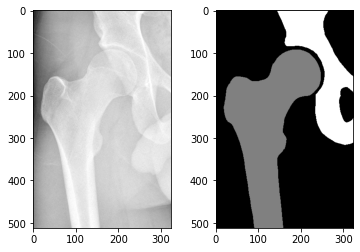

In [ ]:
import nibabel as nib
image=nib.load(train_files[0]['image']).get_fdata()
mask=nib.load(train_files[0]['label']).get_fdata()
print(image.shape,mask.shape)
print(mask.max(),mask.min())
fig,ax=plt.subplots(1,2)
ax[0].imshow(np.squeeze(image,-1),cmap='gray')
ax[1].imshow(np.squeeze(mask,-1),cmap='gray')

In [ ]:
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import DataLoader,Dataset
import torch

In [ ]:
train_aug=A.Compose(
    [
     A.Resize(512,512),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
     A.Rotate(10),
     A.GaussNoise(p=0.1),
     A.Normalize(mean=(0),std=(1)),
     ToTensorV2(p=1.0)
    ]
)


val_aug=A.Compose(
    [
     A.Resize(512,512),
     A.Normalize(mean=(0),std=(1)),
     ToTensorV2(p=1.0)
    ]
)

In [ ]:
class DataReader(Dataset):
  def __init__(self,data,transform):
    self.data=data
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image_path=self.data[index]['image']
    label_path=self.data[index]['label']

    image=nib.load(image_path).get_fdata()
    label=nib.load(label_path).get_fdata()

    transformed=self.transform(image=image,mask=label)
    image=transformed['image']
    label=transformed['mask']
    label=torch.moveaxis(label,2,0)

    return image,label

In [ ]:
sample_data=DataReader(data=data_dicts,transform=train_aug)
sample_loader=DataLoader(sample_data,batch_size=4)
sample_batch=next(iter(sample_loader))

In [ ]:
sample_batch[0].shape,sample_batch[1].shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 1, 512, 512]))

Text(0.5, 1.0, 'batch of masks')

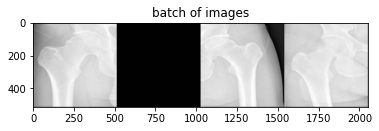

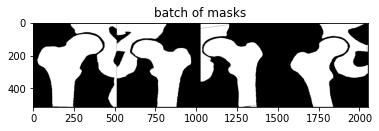

In [ ]:
plt.figure()
grid_image=torchvision.utils.make_grid(sample_batch[0],4,1)
plt.imshow(grid_image.permute(1,2,0))
plt.title('batch of images')
plt.figure()
grid_image=torchvision.utils.make_grid(sample_batch[1],4,1)
plt.imshow(grid_image.permute(1,2,0))
plt.title('batch of masks')

In [ ]:
import segmentation_models_pytorch as smp
from pytorch_lightning import seed_everything,LightningModule,Trainer
import torchmetrics
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentClass(LightningModule):
  def __init__(self):
    super(SegmentClass,self).__init__()

    #model
    self.model = smp.Unet(
        encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,                      # model output channels (number of classes in your dataset)
    )
    #loss function
    self.loss=DiceLoss(mode='multiclass',classes=3,from_logits=True)
    #metric
    self.iou=torchmetrics.JaccardIndex(task="multiclass", num_classes=3)
    #batchsize
    self.batchsize=24
    #lr
    self.lr=1e-3

  def forward(self,x) :
    return self.model(x)
      
  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(),lr=self.lr,weight_decay=1e-5)
    scheduler=CosineAnnealingWarmRestarts(opt,T_0=10,T_mult=1,eta_min=1e-5,last_epoch=-1)
    return {'optimizer':opt,'lr_scheduler':scheduler}

  def train_dataloader(self):
    data=DataReader(data=train_files,transform=train_aug)
    loader=DataLoader(data,batch_size=self.batchsize,shuffle=True)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch[0],torch.squeeze(batch[1],1).long()
    out=self(image)
    loss=self.loss(out,segment)
    iou=self.iou(out,segment)
    self.log('train_loss',loss,on_step=False,on_epoch=True,prog_bar=True)
    self.log('train_iou',iou,on_step=False,on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    data=DataReader(data=val_files,transform=val_aug)
    loader=DataLoader(data,batch_size=self.batchsize,shuffle=False)
    return loader

  def validation_step(self,batch,batch_idx):
    image,segment=batch[0],torch.squeeze(batch[1],1).long()
    out=self(image)
    loss=self.loss(out,segment)
    iou=self.iou(out,segment)
    self.log('val_loss',loss,on_step=False,on_epoch=True,prog_bar=True)
    self.log('val_iou',iou,on_step=False,on_epoch=True,prog_bar=True)
    return loss

In [ ]:
model=SegmentClass()

In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor
lr_monitor=LearningRateMonitor(logging_interval='epoch')

trainer=Trainer(max_epochs=50,gpus=1,precision=16,callbacks=[lr_monitor])

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | Unet                   | 24.4 M
1 | loss  | DiceLoss               | 0     
2 | iou   | MulticlassJaccardIndex | 0     
-------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
48.861    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
model=model.to('cuda')
test_loader=model.val_dataloader()
model.eval()
with torch.no_grad():
  imgs,preds,labels=[],[],[]
  for img,seg in test_loader:
    pred=model(img.to('cuda'))
    pred=torch.sigmoid(pred)
    imgs.append(img)
    preds.append(pred)
    labels.append(seg)

In [ ]:
imgs_array=torch.cat(imgs)
preds_array=torch.cat(preds)
labels_array=torch.cat(labels)
imgs_array.shape,preds_array.shape,labels_array.shape

(torch.Size([28, 1, 512, 512]),
 torch.Size([28, 3, 512, 512]),
 torch.Size([28, 1, 512, 512]))

In [ ]:
imgs_array=torch.squeeze(imgs_array,dim=1)
labels_array=torch.squeeze(labels_array,dim=1)
preds_array=torch.argmax(preds_array,dim=1)
imgs_array.shape,preds_array.shape,labels_array.shape

(torch.Size([28, 512, 512]),
 torch.Size([28, 512, 512]),
 torch.Size([28, 512, 512]))

In [ ]:
imgs_array=imgs_array.detach().numpy()
labels_array=labels_array.detach().numpy()
preds_array=preds_array.detach().cpu().numpy()

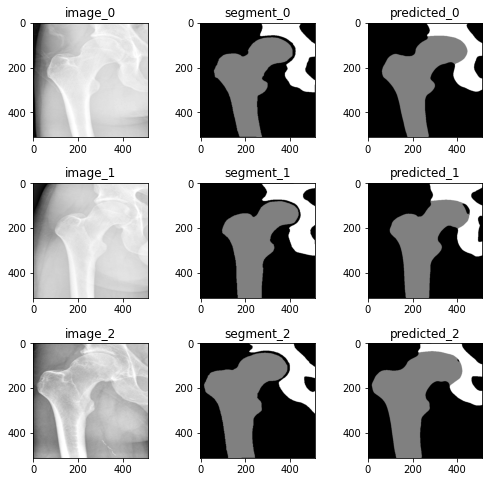

In [ ]:
fig,ax=plt.subplots(3,3,figsize=(16,8))
for i in range(3):
  ax[i,0].imshow(imgs_array[i,:,:],cmap='gray')
  ax[i,0].set_title('image_{}'.format(i))
  ax[i,1].imshow(labels_array[i,:,:],cmap='gray')
  ax[i,1].set_title('segment_{}'.format(i))
  ax[i,2].imshow(preds_array[i,:,:],cmap='gray')
  ax[i,2].set_title('predicted_{}'.format(i))
plt.subplots_adjust(wspace=-0.7, hspace=0.4)